# Reddit Influences Perceptions of COVID-19 Vaccination

- Yuenji Lee

## Introduction
This project analyzes posts and comments on a *Reddit* thread to see whether Reddit influences public opinions about COVID-19 vaccination during the pandemic by sharing unproved myths about COVID-19 vaccine --*"Did Reddit posts about COVID-19 vaccine myths affect the public (not)to get vaccinated?"* Focusing on the central inquiry, we explore the following two research questions in this project:

**Research Question 1** Does the *tone* of Reddit comments impact the public's inclination towards COVID-19 vaccination?

**Research Question 2** Does the *context* of the posts and comments influence the public's perspective on getting vaccinated?

## Dataset Description
The dataset `reddit_vm.csv` is a set of Reddit posts from subreddit **VaccinMyths**. This dataset is a collection of posts and comments on the subreddit VaccineMyths in which Reddit users shared their beliefs about any type of vaccines. Each column represents:
- `title` - relevant for posts
- `score` - based on impact, number of comments (relevant for posts)
- `id` - unique id for posts/comments
- `url` - url of post thread (relevant for posts)
- `commns_num` - number of comments to this post (relevant for post) 
- `created` - date of creation
- `body` - text of the post or comment (relevant for posts/comments)
- `timestamp` - timestamp

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
!pip install nltk
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
!pip install textblob

In [2]:
df = pd.read_csv("reddit_vm.csv")
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


In [3]:
df.describe()

,score,comms_num,created
count,1602.000000,1602.000000,1.602000e+03
mean,3.686642,1.838951,1.547197e+09
std,29.915671,16.115147,7.099511e+07
min,-12.000000,0.000000,1.389595e+09
25%,1.000000,0.000000,1.554367e+09
50%,1.000000,0.000000,1.569226e+09
75%,3.000000,1.000000,1.584901e+09
max,1187.000000,595.000000,1.640822e+09


While we are focusing on the context of COVID-19, we will **only analyze the data from 2019**.
As illustrated below, the posts and comments were in the highest volume in the year 2019. 
I will only extract the data from 2019 and use them for the further analysis.

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter the data for the year 2019
df_2019 = df[df['timestamp'].dt.year == 2019]

# Print the data for the year 2019
print(df_2019.head())

      title  score       id  url  comms_num       created  \
6   Comment      1  ej9x066  NaN          0  1.553474e+09   
9   Comment      0  ej9xuaf  NaN          0  1.553475e+09   
10  Comment      1  ej9x2qr  NaN          0  1.553474e+09   
11  Comment      2  ejacj98  NaN          0  1.553486e+09   
12  Comment      2  ejabpdx  NaN          0  1.553485e+09   

                                                 body           timestamp  
6   Your OP. It's not a myth. Only one vaccine con... 2019-03-25 02:34:53  
9   What do you mean by "your OP". I am fairly new... 2019-03-25 02:45:21  
10  When they say there's no thimerasol, they mean... 2019-03-25 02:35:47  
11  The "myth" you're debunking is in regards to t... 2019-03-25 05:50:20  
12  You'll have to read it again because I didn't ... 2019-03-25 05:40:03  


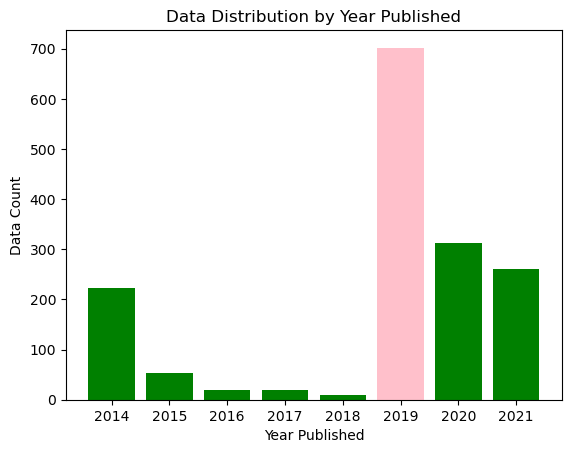

In [5]:
df['year_published'] = df['timestamp'].dt.year
data_count = df['year_published'].value_counts().sort_index()

default_color = 'green'
specific_year_color = 'pink'

# Create the bar graph with default color
plt.bar(data_count.index, data_count.values, color=default_color)
plt.bar(2019, data_count[2019], color=specific_year_color)

plt.xlabel('Year Published')
plt.ylabel('Data Count')
plt.title('Data Distribution by Year Published')

plt.show()

## Preprocessing
It is important to make the text machine friendly before analysis. Hence, we'll apply the following steps to preprocess the text: 

1. Drop unncessary data
2. Tokenization
3. Remove stop words
4. Lemmatization

### 1. Drop Unnecessary Data
To ensure the data contains only relevant information, we will remove any non-essential or duplicate data. The following fields will be dropped: `id`, `url`, and `created`. Since `created` duplicates the information in `timestamp`, we will exclude it from the analysis.

In [6]:
df_2019.dropna(inplace=True)

df_2019[df.duplicated()]
df_2019.drop_duplicates(inplace=True)

df_2019.drop(columns=['id', 'url', 'created'], inplace=True)
df_2019.head()

/tmp/ipykernel_3058/1059033886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019.dropna(inplace=True)
/tmp/ipykernel_3058/1059033886.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2019[df.duplicated()]
/tmp/ipykernel_3058/1059033886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019.drop_duplicates(inplace=True)
/tmp/ipykernel_3058/1059033886.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

,title,score,comms_num,body,timestamp
145,Vaccine Survey,0,5,Hi guys! I was wondering if you could help me ...,2019-01-27 00:42:09
171,Do live vaccines shed?,5,10,After you get a live vaccine do you need to st...,2019-11-26 20:38:14
256,A mom friend is excited her kids got chicken pox,9,5,I posted this on the antivaxxers too because I...,2019-11-25 21:34:13
258,Anti-Vax Nurse?!,7,27,"Sorry if this is the wrong sub, but I don’t kn...",2019-11-15 22:29:12
259,Need help with an anti-vaxxer on Reddit,6,32,Hi all.\n\nThey’re saying things like double-b...,2019-11-09 11:49:39


### 2. Tokenization
By splitting a text into smaller units(tokens), we make the data more concise.

In [7]:
df_2019['body'] = df_2019['body'].apply(word_tokenize)

/tmp/ipykernel_3058/3104133768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['body'] = df_2019['body'].apply(word_tokenize)


### 3. Remove Stop Words
Stopwords are common words that don't carry much meaning which are not needed for the analysis.

In [8]:
stopwords_list = set(stopwords.words('english'))
df_2019['body'] = df_2019['body'].apply(lambda x: [word for word in x if word not in stopwords_list])

/tmp/ipykernel_3058/3401962272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['body'] = df_2019['body'].apply(lambda x: [word for word in x if word not in stopwords_list])


In [9]:
# Make it cleaner

def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df_2019['body'] = df_2019['body'].apply(clean_text)

/tmp/ipykernel_3058/1593397030.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['body'] = df_2019['body'].apply(clean_text)


In [10]:
df_2019['body'].head()

145    Hi guys I wondering could help research projec...
171    After get live vaccine need stay away elderly ...
256    I posted antivaxxers I know belongs I guess ma...
258    Sorry wrong sub I know else post My dad dying ...
259    Hi They saying things like doubleblind studies...
Name: body, dtype: object

## Analysis (+ Visualization)

- **Research Question 1** Does the *tone* of Reddit comments impact the public's inclination towards COVID-19 vaccination?

For the first research question, I analyze the *sentiment and tone* of comments on Reddit posts about COVID-19 vaccines. This can involve **sentiment analysis** to determine the positive, negative, or neutral sentiment of comments. Additionally, I analyze the **sentiment distribution** and identify any *correlations* between comment tones and users' perceptions or decisions regarding vaccination.

### *1-1. Sentiment Analysis*
chose this because... it identifies the sentiment(emotion) of such text. By seeing whether the comments and captions are toned positive or negative, we can assume if Reddit positively or negatively affected the public.

In [11]:
def get_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(str(text))
    sentiment_polarity = sentiment_scores['compound']
    return sentiment_polarity

# Apply sentiment analysis using the custom function
df_2019['sentiment'] = df_2019['body'].apply(get_sentiment)

# Print the sentiment analysis results for the year 2019
print(df_2019[['body', 'sentiment']].head())

                                                  body  sentiment
145  Hi guys I wondering could help research projec...     0.6597
171  After get live vaccine need stay away elderly ...     0.9097
256  I posted antivaxxers I know belongs I guess ma...     0.9659
258  Sorry wrong sub I know else post My dad dying ...    -0.9287
259  Hi They saying things like doubleblind studies...     0.7279


/tmp/ipykernel_3058/1694646052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['sentiment'] = df_2019['body'].apply(get_sentiment)


### *1-2. Sentiment Distribution*
By looking at the distribution of each sentiment(Positive, Neutral, or Negative), we can expect the possibility of influence of Reddit posts on the public's perceptions or decisions regarding COVID-19 vaccination.

In [12]:
positive_count = df_2019[df_2019['sentiment'] > 0].shape[0]
neutral_count = df_2019[df_2019['sentiment'] == 0].shape[0]
negative_count = df_2019[df_2019['sentiment'] < 0].shape[0]

print("Positive count:", positive_count)
print("Neutral count:", neutral_count)
print("Negative count:", negative_count)

Positive count: 20
Neutral count: 4
Negative count: 14


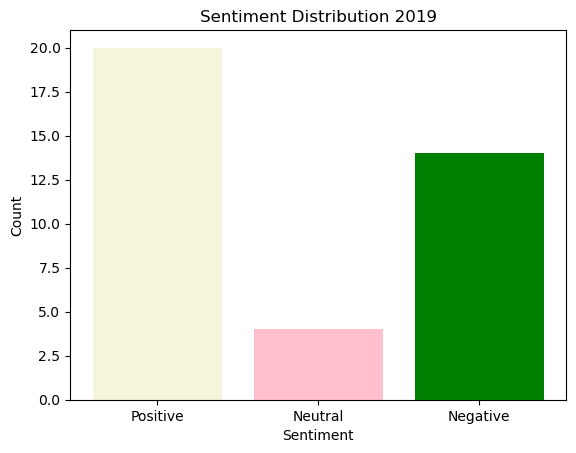

In [13]:
labels = ['Positive', 'Neutral', 'Negative']
values = [positive_count, neutral_count, negative_count]
colors = ['beige', 'pink', 'green']

plt.bar(labels, values, color=colors)
plt.title('Sentiment Distribution 2019')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.show()

These results indicate that the dataset contains a mix of positive, neutral, and negative sentiments. The majority of the sentiments are either positive or negative, with a slightly higher count of positive sentiments compared to negative ones. The neutral count falls in between, representing a significant portion of the dataset.

- **Research Question 2** Does the *context* of the posts and comments influence the public's perspective on getting vaccinated?

To explore the second research question, I analyze the **engagement metrics** of posts related to COVID-19 vaccines, such as upvotes, comments, and user participation(which are indicated numarically as `comms_num`). Additionally, **sentiment analysis** can help determine the overall sentiment of these discussions and identify patterns or trends in public opinions.

### *2-1. Collocation Analysis*
Collocation analysis identifies the main theme/topic about the dataset by analyzing the most used/occurred words.
This information can be useful in understanding public opinion and sentiment, as well as the language patterns used by users.

In [14]:
def find_collocations(text, num_collocations=10):
    text = ' '.join(df_2019['body'].astype(str))
    tokens = nltk.word_tokenize(text)
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(2)
    finder.apply_word_filter(lambda w: w.lower() in stopwords.words('english') or w in string.punctuation)
    return finder.nbest(bigram_measures.pmi, num_collocations)

In [15]:
body = df_2019['body']

collocations = find_collocations(body)
collocations

[('Health', 'Service'),
 ('Hey', 'podcast'),
 ('Public', 'Health'),
 ('TT', 'skew'),
 ('across', 'brash'),
 ('anti', 'vaxxers'),
 ('come', 'across'),
 ('gastrointestinal', 'issues'),
 ('helming', 'pro'),
 ('highly', 'regarded')]

The collocation analysis revealed several interesting patterns within the dataset. Some notable collocations include "Health Service," "Hey podcast," "Public Health," "TT skew," "across brash," "anti-vaxxers," "come across," "gastrointestinal issues," "helming pro," and "highly regarded." These collocations provide insights into the prevalent topics and themes discussed in the dataset. 

- The presence of terms like *"Health Service"* and *"Public Health"* suggests a focus on **healthcare-related discussions**, potentially related to the COVID-19 vaccine. 

- Other collocations such as *"anti-vaxxers"* indicate the presence of discussions or debates regarding **vaccine skepticism or opposition**. The term "anti-vaxxers" refers to individuals or groups who are against vaccinations. Its frequent occurrence as a collocation suggests a focus on discussions, opinions, or information related to vaccine skepticism or opposition. 

- Additionally, terms like *"gastrointestinal issues"* and *"highly regarded"* may indicate specific **concerns** or opinions expressed by the community. The collocation "gastrointestinal issues" implies a specific emphasis on health problems or concerns related to the digestive system.

## Results/Findings

In conclusion, this analysis aimed to investigate the presence of vaccine myths in the data and their potential impact on the public's vaccination decisions. 

The sentiment analysis revealed that there is a slightly higher prevalence of positive sentiments among the examples analyzed. While this suggests a relatively more optimistic outlook, it is important to note that sentiments expressed in the dataset only reflect the perspectives of the authors and commenters. The positive sentiments observed may indicate a generally favorable perception of vaccines within the dataset. Yet, it remains uncertain whether these sentiments have directly influenced others or significantly impacted the actual vaccination numbers.

The collocation analysis uncovered recurring phrases and word combinations, highlighting key topics and sentiments within the dataset. These collocations reveal discussions on health services, public health, vaccine skepticism, specific health issues, and expressions of concerns. These findings contribute to understanding the prevalent themes and language patterns in the dataset.

However, it is essential to acknowledge the limitations of this analysis. Technology limitations may impact the accuracy of analyzing social media posts, and the dataset's representativeness is limited to the specific Reddit thread analyzed. Additionally, focusing solely on COVID-19 vaccines may introduce biases and hinder the collection of broader public opinions for a comprehensive analysis.

In summary, this analysis provides insights into the sentiments and collocations present in the dataset, but further research and consideration of the limitations are necessary to gain a comprehensive understanding of the broader impact on public perceptions and vaccination behavior.

## Contribution
Yuenji Lee: 100%